# <a id='toc1_'></a>[Assignment 4: Cartographic Map](#toc0_)

**Spatial Data Analytics (GEOM90006)**

**Semester 1, 2025**  
**Date:** 14 May, 2025  

**Group:** 26

---

**Table of contents**<a id='toc0_'></a>    
- [Assignment 4: Cartographic Map](#toc1_)    
  - [Load the data](#toc1_1_)    
    - [Load the SA2 shape file](#toc1_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---

In [1]:
# Importing Required Packages

# --- Data Analysis ---
import pandas as pd
import numpy as np

# --- Geo ---
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.io import MemoryFile

# --- Visualization ---
import matplotlib.pyplot as plt


---

## <a id='toc1_1_'></a>[Load the data](#toc0_)

### <a id='toc1_1_1_'></a>[Load the SA2 shape file](#toc0_)

In [2]:
sa2 = gpd.read_file('Data/SA2_2016_AUST.shp')
print(sa2.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SA2_MAIN16  2310 non-null   object  
 1   SA2_5DIG16  2310 non-null   object  
 2   SA2_NAME16  2310 non-null   object  
 3   SA3_CODE16  2310 non-null   object  
 4   SA3_NAME16  2310 non-null   object  
 5   SA4_CODE16  2310 non-null   object  
 6   SA4_NAME16  2310 non-null   object  
 7   GCC_CODE16  2310 non-null   object  
 8   GCC_NAME16  2310 non-null   object  
 9   STE_CODE16  2310 non-null   object  
 10  STE_NAME16  2310 non-null   object  
 11  AREASQKM16  2310 non-null   float64 
 12  geometry    2292 non-null   geometry
dtypes: float64(1), geometry(1), object(11)
memory usage: 234.7+ KB
None


In [3]:
display(sa2.head())

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."


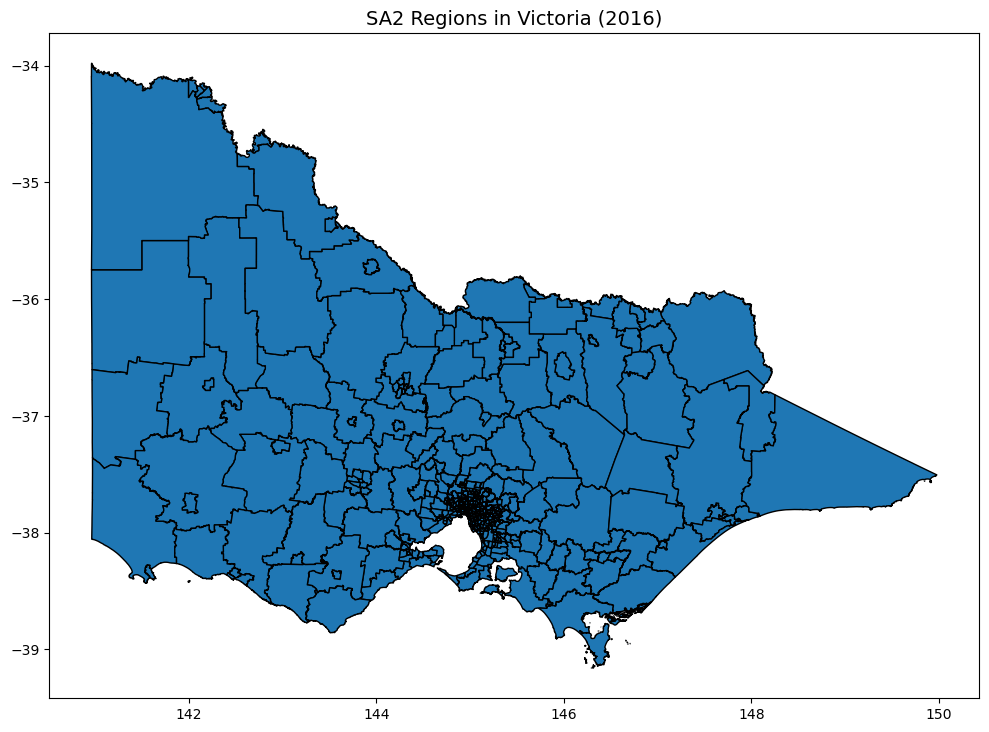

In [4]:
vicSA2 = sa2[sa2['STE_NAME16'] == 'Victoria']

vicSA2.plot(figsize=(12, 12), edgecolor='black')
plt.title('SA2 Regions in Victoria (2016)', fontsize=14)
plt.show()

In [5]:
targetSubs = [
    'Alphington', 'Footscray', 'Churchill', 'Moe',
    'Morwell – East', 'Morwell – South', 'Traralgon'
]
subsSA2 = vicSA2[vicSA2['SA2_NAME16'].isin(targetSubs)]

In [6]:
epaDF = pd.read_excel('Data/All_sites_air_quality_hourly_avg_AIR.xlsx', sheet_name=0)


In [7]:
epaDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401438 entries, 0 to 401437
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   sample_point_id            401438 non-null  int64         
 1   sp_name                    401438 non-null  object        
 2   latitude                   401438 non-null  float64       
 3   longitude                  401438 non-null  float64       
 4   sample_datetime            401438 non-null  datetime64[ns]
 5   time_basis_id              401438 non-null  object        
 6   param_id                   401438 non-null  object        
 7   param_name                 401438 non-null  object        
 8   value                      401438 non-null  float64       
 9   param_std_unit_of_measure  401438 non-null  object        
 10  param_short_name           401143 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(6

In [8]:
epa25 = epaDF[epaDF["param_short_name"] == 'PM2.5']
epa25.reset_index(drop=True, inplace=True)
epa25.head()

,sample_point_id,sp_name,latitude,longitude,sample_datetime,time_basis_id,param_id,param_name,value,param_std_unit_of_measure,param_short_name
0,10001,Alphington,-37.778408,145.030594,2016-01-01 00:00:00,1HR_AV,BPM2.5,BAM Particles < 2.5 micron,9.3,ug/m3,PM2.5
1,10001,Alphington,-37.778408,145.030594,2016-01-01 01:00:00,1HR_AV,BPM2.5,BAM Particles < 2.5 micron,13.3,ug/m3,PM2.5
2,10001,Alphington,-37.778408,145.030594,2016-01-01 02:00:00,1HR_AV,BPM2.5,BAM Particles < 2.5 micron,14.9,ug/m3,PM2.5
3,10001,Alphington,-37.778408,145.030594,2016-01-01 03:00:00,1HR_AV,BPM2.5,BAM Particles < 2.5 micron,15.0,ug/m3,PM2.5
4,10001,Alphington,-37.778408,145.030594,2016-01-01 04:00:00,1HR_AV,BPM2.5,BAM Particles < 2.5 micron,15.7,ug/m3,PM2.5


In [9]:
stations = (
    epa25[['sp_name', 'latitude', 'longitude']]
    .drop_duplicates(subset=['sp_name'])
    .rename(columns={'sp_name': 'Site', 'latitude': 'Latitude', 'longitude': 'Longitude'})
)

stationsGDF = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude),
    crs='EPSG:4283'
)

vicSA2 = vicSA2.to_crs(epsg=7855)
subsSA2 = subsSA2.to_crs(epsg=7855)
stationsGDF = stationsGDF.to_crs(epsg=7855)

In [27]:
stationsGDF

,Site,Latitude,Longitude,geometry
0,Alphington,-37.778408,145.030594,POINT (326564.305 5816945.645)
7563,Churchill,-38.304314,146.414932,POINT (448845.887 5760259.431)
16187,Footscray,-37.804878,144.872803,POINT (312733.698 5813703.828)
24507,Geelong South,-38.173561,144.370300,POINT (269645.805 5771660.751)
27693,Moe,-38.186466,146.258331,POINT (435048.747 5773237.390)
36050,Morwell East,-38.229393,146.424454,POINT (449626.666 5768577.736)
42327,Morwell South,-38.239292,146.387299,POINT (446381.963 5767458.481)
50932,Traralgon,-38.194283,146.531464,POINT (458972.895 5772526.296)


In [10]:
raster = rasterio.open('Data/Native Vegetation Cover.tif')

dstCRS = 'EPSG:7855'

transform, width, height = calculate_default_transform(
    raster.crs, dstCRS, raster.width, raster.height, *raster.bounds
)

profile = raster.profile.copy()
profile.update({
    'crs': dstCRS,
    'transform': transform,
    'width': width,
    'height': height
})

In [11]:
with MemoryFile() as memfile:
    with memfile.open(**profile) as dst:
        reproject(
            source=raster.read(1),
            destination=rasterio.band(dst, 1),
            src_transform=raster.transform,
            src_crs=raster.crs,
            dst_transform=transform,
            dst_crs=dstCRS,
            resampling=Resampling.nearest
        )
        projRaster = dst.read(1)
        projTransform = dst.transform

In [14]:
victoria_poly = vicSA2.dissolve(by='STE_NAME16').geometry.unary_union

# 2. Create a GeoSeries for plotting
victoria_border = gpd.GeoSeries([victoria_poly], crs=vicSA2.crs)

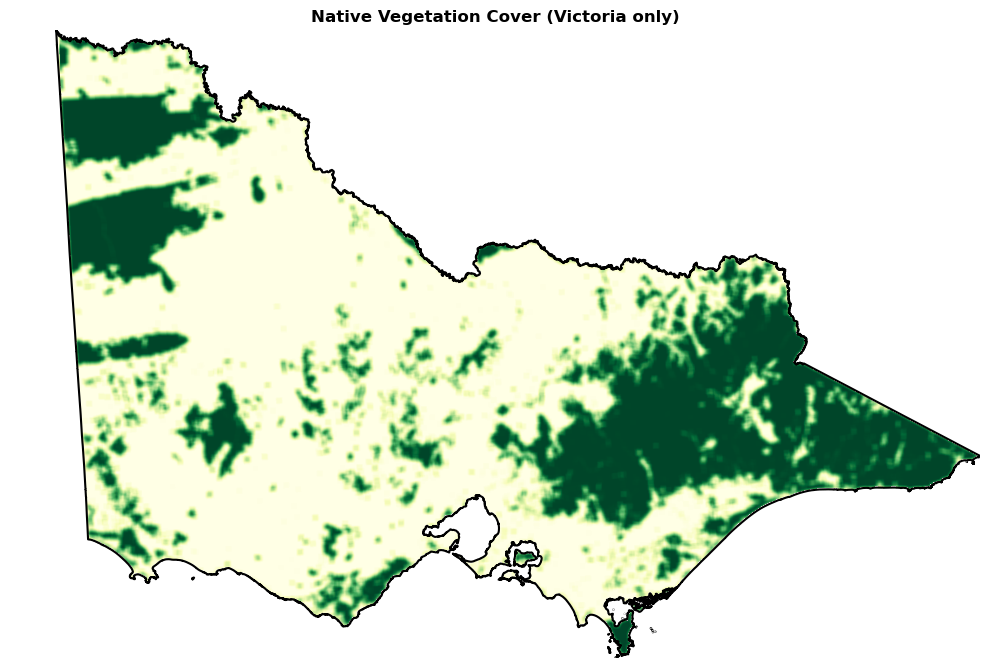

In [22]:
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.io import MemoryFile
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import mapping

# --- 1. Reproject the original raster into EPSG:7855 ---

dst_crs = "EPSG:7855"
src = rasterio.open("Data/Native Vegetation Cover.tif")

transform, w, h = calculate_default_transform(
    src.crs, dst_crs, src.width, src.height, *src.bounds
)
profile = src.profile.copy()
profile.update({
    "crs": dst_crs,
    "transform": transform,
    "width": w,
    "height": h,
    "driver": "GTiff",
    "count": 1
})

with MemoryFile() as memfile:
    with memfile.open(**profile) as dst:
        reproject(
            source=src.read(1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

        # --- 2. Clip to Victoria, asking for a masked array (filled=False) ---
        # Make sure victoria_border is already in EPSG:7855
        victoria_geom = [mapping(victoria_border.geometry.iloc[0])]
        clipped_data, clipped_transform = mask(
            dst,
            shapes=victoria_geom,
            crop=True,
            filled=False      # <— returns a numpy.ma.MaskedArray
        )

# clipped_data.shape == (1, H, W); use clipped_data[0]
veg = clipped_data[0]

# --- 3. Plot, letting the mask be transparent, and overlay the border ---
fig, ax = plt.subplots(figsize=(10, 10))

# show() knows how to handle masked arrays: masked pixels won’t be drawn
show(
    veg,
    transform=clipped_transform,
    ax=ax,
    cmap="YlGn",      # yellow-green palette for vegetation
    title="Native Vegetation Cover (Victoria only)"
)

# boundary on top
victoria_border.boundary.plot(
    ax=ax,
    edgecolor="black",
    linewidth=1.5
)

ax.set_axis_off()
plt.tight_layout()
plt.show()

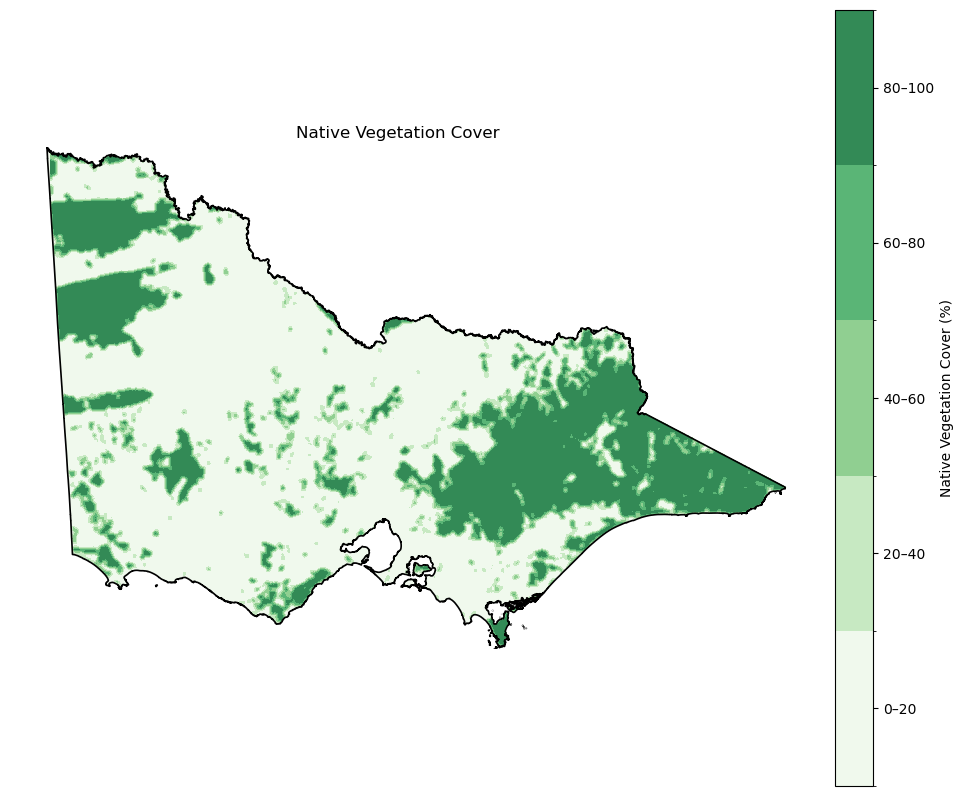

In [24]:
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt

# — assume you already have:
#   veg            = clipped_data[0]         # numpy.ma.MaskedArray of your veg cover
#   clipped_transform
#   victoria_border  (GeoSeries in EPSG:7855)

# 1. Define class breaks (e.g. % cover) and matching colours
breaks = [0, 20, 40, 60, 80, 100]  
colors = ["#edf8e9", "#bae4b3", "#74c476", "#31a354", "#006d2c"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(breaks, ncolors=cmap.N, clip=True)

# 2. Compute the map extent so we can use imshow
extent = plotting_extent(veg, clipped_transform)

# 3. Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Draw the vegetation classes
im = ax.imshow(
    veg, 
    extent=extent, 
    cmap=cmap, 
    norm=norm, 
    alpha=0.8,      # slight transparency
    interpolation="nearest"
)

# Overlay the Victoria border
victoria_border.boundary.plot(
    ax=ax,
    edgecolor="black",
    linewidth=1.2
)

# 4. Legend / Colorbar
cbar = fig.colorbar(
    im, 
    ax=ax, 
    boundaries=breaks,
    ticks=[(breaks[i] + breaks[i+1]) / 2 for i in range(len(breaks)-1)],
    spacing="proportional",
    shrink=0.8
)
cbar.set_label("Native Vegetation Cover (%)")
cbar.ax.set_yticklabels([
    f"{breaks[i]}–{breaks[i+1]}" for i in range(len(breaks)-1)
])

# 5. Finishing touches
ax.set_title("Native Vegetation Cover")  
ax.set_axis_off()
plt.tight_layout()
plt.show()

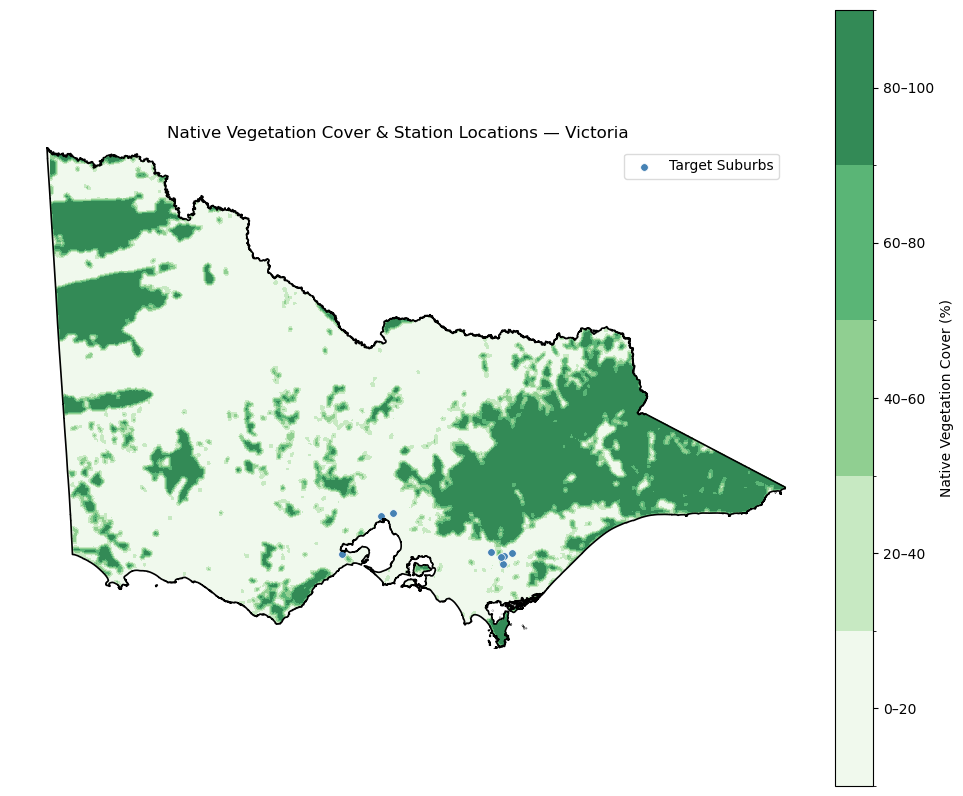

In [26]:
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt

# — assume you already have:
#    veg                  = clipped_data[0]         # numpy.ma.MaskedArray
#    clipped_transform
#    victoria_border      = GeoSeries in EPSG:7855
#    stationsGDF          = GeoDataFrame of your points

# 1. Define classes and colours
breaks = [0, 20, 40, 60, 80, 100]  
colors = ["#edf8e9", "#bae4b3", "#74c476", "#31a354", "#006d2c"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(breaks, ncolors=cmap.N, clip=True)

# 2. Compute extent
extent = plotting_extent(veg, clipped_transform)

# 3. Start plotting
fig, ax = plt.subplots(figsize=(10, 10))

# 3a. Draw the vegetation
im = ax.imshow(
    veg,
    extent=extent,
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    interpolation="nearest"
)

# 3b. Draw Victoria boundary
victoria_border.boundary.plot(
    ax=ax,
    edgecolor="black",
    linewidth=1.2
)

# 3c. Overlay station points
stationsGDF.to_crs(epsg=7855).plot(
    ax=ax,
    marker="o",
    markersize=30,
    facecolor="steelblue",
    edgecolor="white",
    linewidth=0.5,
    label="Target Suburbs"
)

# 4. Colourbar legend for the vegetation classes
cbar = fig.colorbar(
    im,
    ax=ax,
    boundaries=breaks,
    ticks=[(b0 + b1)/2 for b0, b1 in zip(breaks[:-1], breaks[1:])],
    spacing="proportional",
    shrink=0.8
)
cbar.set_label("Native Vegetation Cover (%)")
cbar.ax.set_yticklabels([f"{b0}–{b1}" for b0, b1 in zip(breaks[:-1], breaks[1:])])

# 5. Add station legend, title & tidy up
ax.legend(loc="upper right", framealpha=0.7)
ax.set_title("Native Vegetation Cover & Station Locations — Victoria")
ax.set_axis_off()
plt.tight_layout()
plt.show()

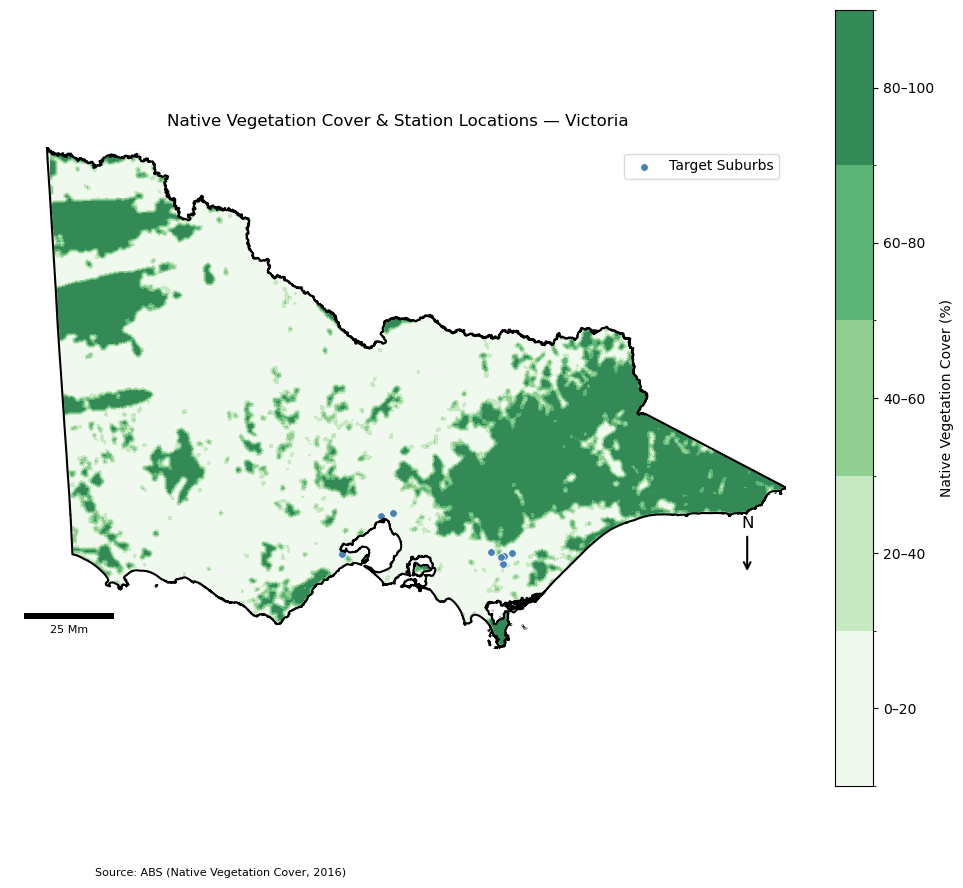

In [30]:
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.plot import plotting_extent
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# — assume you already have:
#    veg                  = clipped_data[0]         # numpy.ma.MaskedArray
#    clipped_transform
#    victoria_border      = GeoSeries in EPSG:7855
#    stationsGDF          = GeoDataFrame of your points

# 1. Classes & colours
breaks = [0, 20, 40, 60, 80, 100]
colors = ["#edf8e9", "#bae4b3", "#74c476", "#31a354", "#006d2c"]
cmap, norm = ListedColormap(colors), BoundaryNorm(breaks, len(colors), clip=True)

# 2. Map extent
extent = plotting_extent(veg, clipped_transform)

# 3. Draw base map
fig, ax = plt.subplots(figsize=(10, 10))

# 3a. Vegetation
im = ax.imshow(
    veg,
    extent=extent,
    cmap=cmap, norm=norm,
    alpha=0.8,
    interpolation="nearest"
)

# 3b. Victoria neatline (border)
victoria_border.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

# 3c. Stations
stationsGDF.to_crs(epsg=7855).plot(
    ax=ax,
    marker="o",
    markersize=30,
    facecolor="steelblue",
    edgecolor="white",
    linewidth=0.5,
    label="Target Suburbs"
)

# 4. Legend (L)
#   - Colourbar for classes
cbar = fig.colorbar(
    im, ax=ax, boundaries=breaks,
    ticks=[(b0 + b1)/2 for b0, b1 in zip(breaks[:-1], breaks[1:])],
    spacing="proportional", shrink=0.8
)
cbar.set_label("Native Vegetation Cover (%)")
cbar.ax.set_yticklabels([f"{b0}–{b1}" for b0, b1 in zip(breaks[:-1], breaks[1:])])

#   - Point legend
ax.legend(loc="upper right", framealpha=0.7)

# 5. Title (T)
ax.set_title("Native Vegetation Cover & Station Locations — Victoria", pad=15)

# 6. North arrow (O)
ax.annotate(
    'N',
    xy=(0.95, 0.15), xytext=(0.95, 0.25),
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
    ha='center', va='center',
    fontsize=12,
    xycoords='axes fraction'
)

# 7. Scale bar (S)
scalebar = ScaleBar(
    dx=abs(clipped_transform.a),    # pixel size in metres
    units="m",
    location="lower left",
    pad=0.5,
    border_pad=0.5,
    scale_loc="bottom",
    box_alpha=0.5,
    font_properties={'size':8}
)
ax.add_artist(scalebar)

# 8. Source & credits (S)
fig.text(
    0.1, 0.02,
    "Source: ABS (Native Vegetation Cover, 2016)",
    ha='left', va='bottom',
    fontsize=8
)

# 9. Neatline frame around the whole map (B)
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1)

# Final clean-up
ax.set_axis_off()
plt.tight_layout()
plt.show()

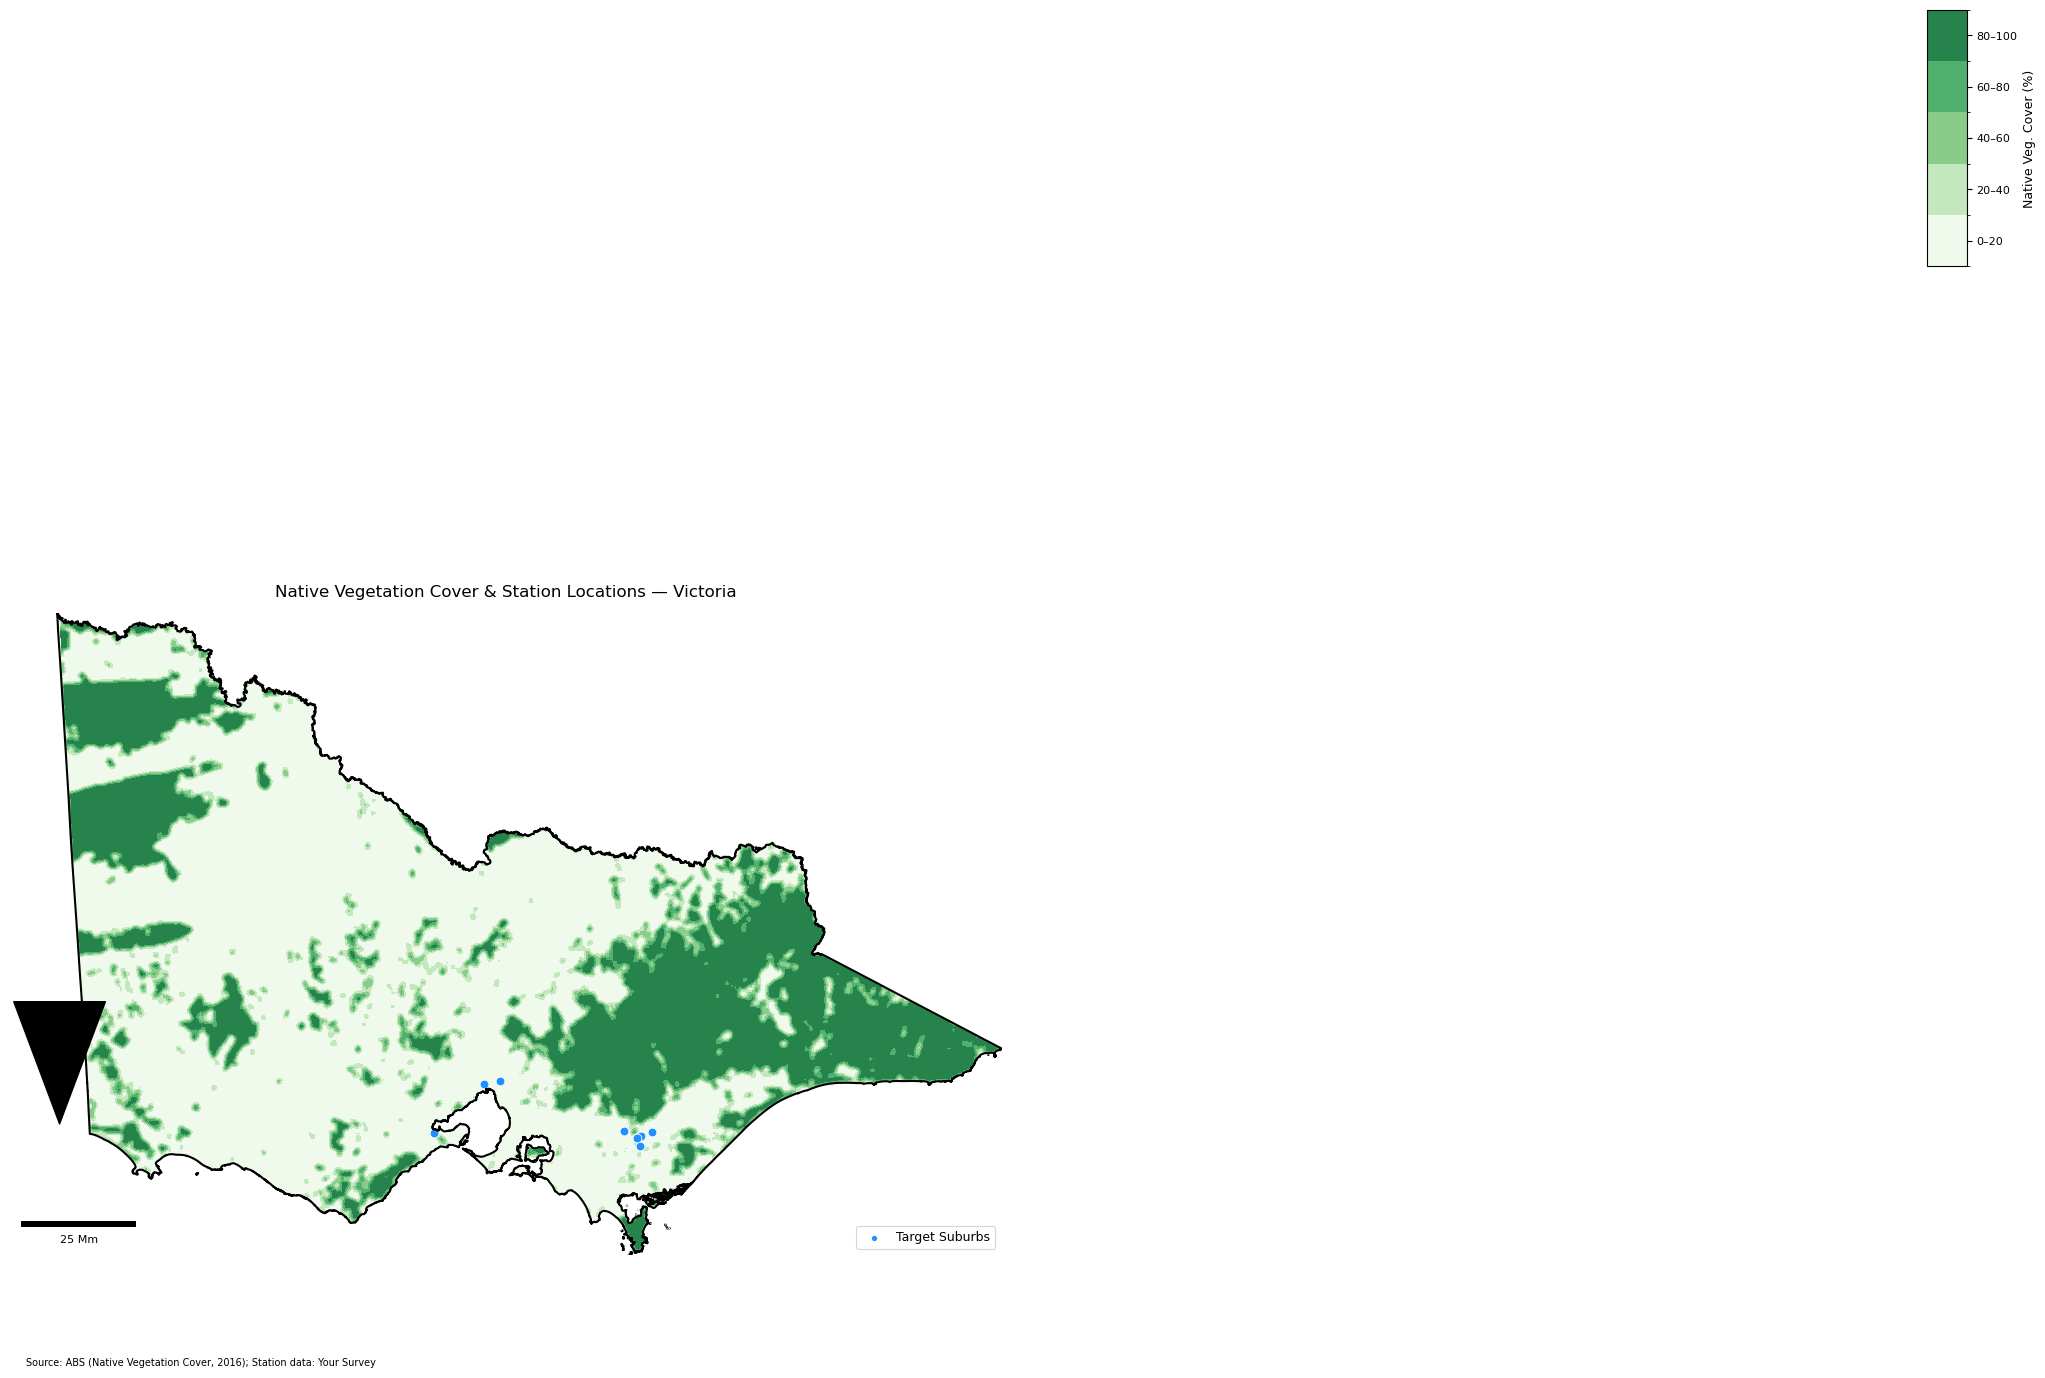

In [31]:
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.plot import plotting_extent
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# — your inputs —
# veg, clipped_transform, victoria_border, stationsGDF already defined in EPSG:7855

# 1. Classes & colours
breaks = [0, 20, 40, 60, 80, 100]
colors = ["#edf8e9", "#bae4b3", "#74c476", "#31a354", "#006d2c"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(breaks, ncolors=len(colors), clip=True)

# 2. Compute extent
extent = plotting_extent(veg, clipped_transform)

# 3. Make figure & axis with constrained layout
fig, ax = plt.subplots(figsize=(10, 9), constrained_layout=True)

# 4. Plot vegetation
im = ax.imshow(
    veg,
    extent=extent,
    cmap=cmap,
    norm=norm,
    alpha=0.85,
    interpolation="nearest"
)

# 5. Victoria neatline
victoria_border.boundary.plot(ax=ax, edgecolor="k", linewidth=1.5)

# 6. Stations
stationsGDF.to_crs(epsg=7855).plot(
    ax=ax, marker="o", markersize=40,
    facecolor="dodgerblue", edgecolor="white", lw=0.6,
    label="Target Suburbs"
)

# 7. Inset colourbar (L)
cax = inset_axes(
    ax,
    width="4%",   # width of colourbar
    height="40%", # height of colourbar
    loc="upper right",
    bbox_to_anchor=(0.98, 0.95, 1, 1),
    bbox_transform=ax.transAxes
)
cbar = fig.colorbar(
    im, cax=cax, boundaries=breaks,
    ticks=[(b0 + b1)/2 for b0, b1 in zip(breaks[:-1], breaks[1:])],
    spacing="proportional"
)
cbar.set_label("Native Veg. Cover (%)", fontsize=9)
cbar.ax.set_yticklabels([f"{b0}–{b1}" for b0, b1 in zip(breaks[:-1], breaks[1:])])
cbar.ax.tick_params(labelsize=8)

# 8. Legend for points (L)
leg = ax.legend(
    loc="lower right",
    framealpha=0.8,
    markerscale=0.7,
    fontsize=9
)
leg.get_frame().set_linewidth(0.8)

# 9. Title (T)
ax.set_title(
    "Native Vegetation Cover & Station Locations — Victoria",
    fontsize=12,
    pad=12
)

# 10. North arrow (O)
ax.annotate(
    'N',
    xy=(0.05, 0.20), xytext=(0.05, 0.30),
    xycoords='axes fraction',
    textcoords='axes fraction',
    ha='center', va='center',
    arrowprops=dict(arrowstyle="Simple,tail_width=0.5,head_width=6,head_length=8", color="k"),
    fontsize=11
)

# 11. Scale bar (S)
#   dx in metres → convert to km
dx_m = abs(clipped_transform.a)
scalebar = ScaleBar(
    dx=dx_m / 1000,  # each pixel = dx_m metres → /1000 for km
    units="km",
    location="lower left",
    pad=0.3,
    border_pad=0.5,
    scale_loc="bottom",
    box_alpha=0.5,
    font_properties={'size':8}
)
ax.add_artist(scalebar)

# 12. Source credit (S)
fig.text(
    0.02, 0.02,
    "Source: ABS (Native Vegetation Cover, 2016); Station data: Your Survey",
    fontsize=7,
    ha='left'
)

# 13. Neatline (B) — already drawn by spines; ensure it’s visible
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.0)
    spine.set_color("black")

# Final touches
ax.set_axis_off()
plt.show()

/var/folders/_6/yglxq74n2dj55b163f87xy580000gn/T/ipykernel_97817/2621703852.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


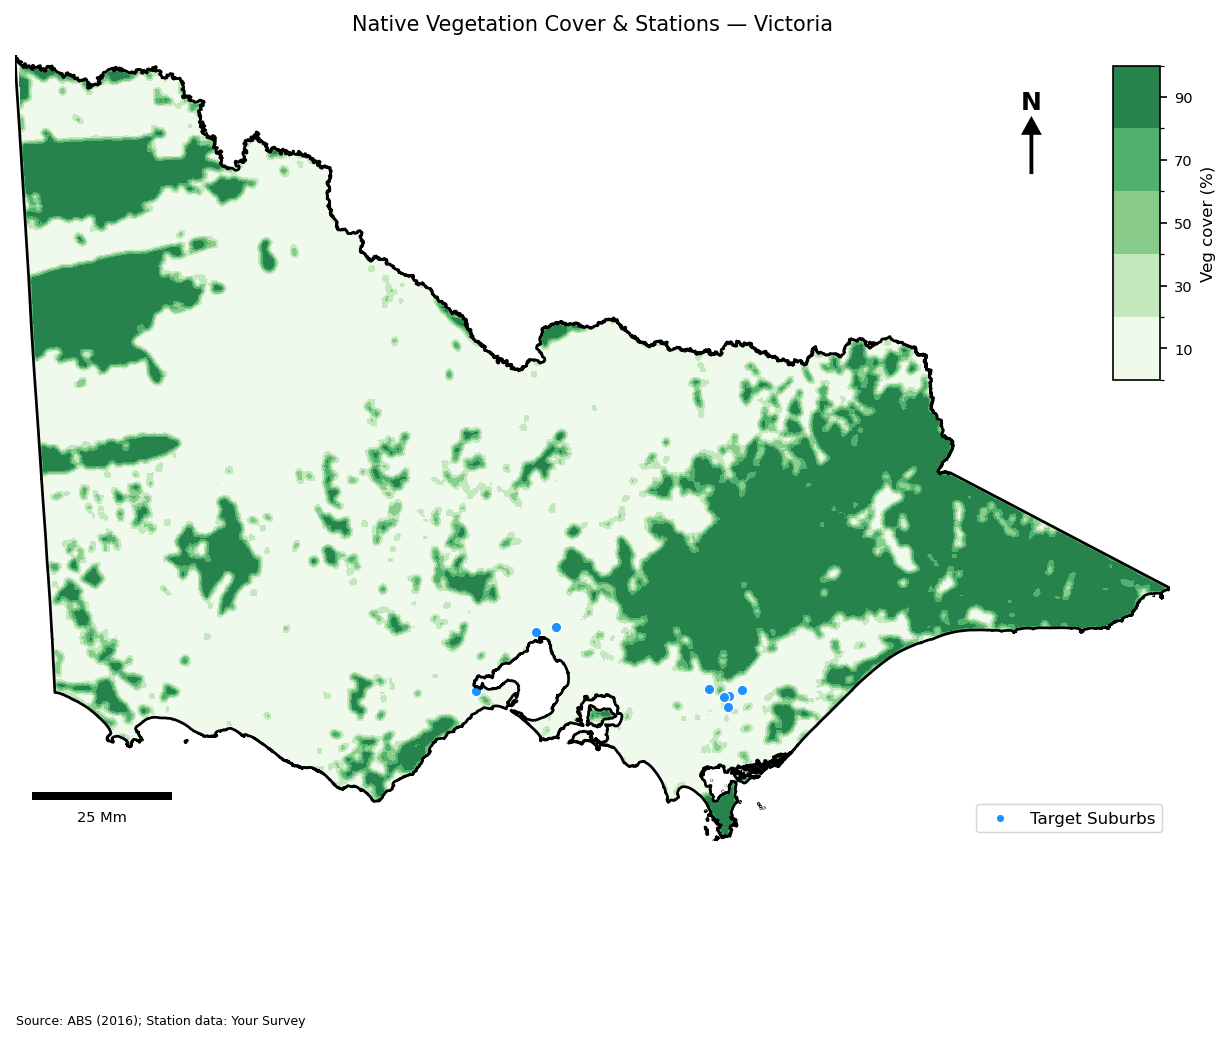

In [37]:
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.plot import plotting_extent
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

# — inputs already defined —
# veg, clipped_transform, victoria_border, stationsGDF

# 1. Classes & colours
breaks = [0,20,40,60,80,100]
colors = ["#edf8e9","#bae4b3","#74c476","#31a354","#006d2c"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(breaks, len(colors), clip=True)

# 2. Extent of the clipped raster
xmin, xmax, ymin, ymax = plotting_extent(veg, clipped_transform)

# 3. Figure + Axes
fig, ax = plt.subplots(figsize=(8,8), dpi=150)
# ensure we only see the map area
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')

# 4. Plot the veg layer
im = ax.imshow(
    veg,
    extent=(xmin, xmax, ymin, ymax),
    cmap=cmap, norm=norm,
    alpha=0.85, interpolation="nearest"
)

# 5. Victoria neatline
victoria_border.boundary.plot(ax=ax, edgecolor="k", linewidth=1.3)

# 6. Stations
stationsGDF.to_crs(epsg=7855).plot(
    ax=ax, marker="o", markersize=25,
    facecolor="dodgerblue", edgecolor="white", lw=0.6,
    label="Target Suburbs"
)

# 7. Inset Colourbar
cax = inset_axes(
    ax, width="4%", height="40%",
    loc="upper right", borderpad=0.5
)
cbar = fig.colorbar(
    im, cax=cax, boundaries=breaks,
    ticks=[(b0 + b1)/2 for b0, b1 in zip(breaks[:-1], breaks[1:])],
    spacing="proportional"
)
cbar.set_label("Veg cover (%)", fontsize=8)
cbar.ax.tick_params(labelsize=7)

# 8. Legend for points
leg = ax.legend(
    loc="lower right", framealpha=0.8,
    markerscale=0.8, fontsize=8
)
leg.get_frame().set_linewidth(0.7)

# 9. North arrow — now positioned just left of the colourbar
#    we use axes fraction coords around x=0.88 so it doesn’t overlap the colourbar
ax.text(
    0.88, 0.94, 'N',
    transform=ax.transAxes,
    fontsize=12, fontweight='bold',
    ha='center', va='center'
)
ax.arrow(
    0.88, 0.85, 0, 0.05,
    transform=ax.transAxes,
    width=0.0015, head_width=0.015, head_length=0.02,
    fc='k', ec='k'
)

# 10. Scale bar in km
dx = abs(clipped_transform.a)  # metres per pixel
scalebar = ScaleBar(
    dx/1000, units='km', location='lower left',
    pad=0.3, border_pad=0.5, box_alpha=0.5,
    font_properties={'size':7}
)
ax.add_artist(scalebar)

# 11. Title & credit
ax.set_title("Native Vegetation Cover & Stations — Victoria", pad=12, fontsize=10)
fig.text(
    0.02, 0.02,
    "Source: ABS (2016); Station data: Your Survey",
    fontsize=6
)

# 12. Clean frame
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("black")
ax.set_axis_off()

plt.tight_layout()
plt.show()